# 4 OpenML Datasets for SG-FIGS

**Artifact:** Dataset collection for evaluating Synergy-Guided FIGS (SG-FIGS).

This notebook demonstrates how the dataset was built from 4 OpenML binary classification datasets matching the RO-FIGS paper (arxiv 2504.06927):
1. **monks2** (OpenML 334) — 601 examples, 6 categorical features, XOR synergy benchmark
2. **blood** (OpenML 1464) — 748 examples, 4 numeric features, blood transfusion prediction
3. **climate** (OpenML 1467) — 540 examples, 20 numeric features, climate model simulation crashes
4. **kc2** (OpenML 1063) — 522 examples, 21 numeric features, NASA software defect prediction

The demo loads a curated mini subset (monks2 + blood) and replicates the processing pipeline: fold assignment, missing value imputation, XOR synergy verification via mutual information, and schema-compliant example construction.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All imports (numpy, pandas, sklearn, matplotlib) are pre-installed on Colab.
# Install locally only, at Colab's exact versions.
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
from itertools import combinations

import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Load Data

Load the curated mini dataset from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/dataset_iter2_4_openml_datase/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} datasets:")
for ds in data['datasets']:
    print(f"  - {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 2 datasets:
  - monks2: 60 examples
  - blood: 10 examples


## Configuration

Tunable parameters for the dataset processing pipeline.

In [5]:
# ── Config ────────────────────────────────────────────────────────
N_SPLITS = 5          # Number of cross-validation folds
RANDOM_STATE = 42     # Random seed for reproducibility
MAX_EXAMPLES = None   # Max examples per dataset (None = use all)

## Dataset Configuration

Define metadata for the 4 OpenML datasets selected for SG-FIGS evaluation.

In [6]:
# ── Dataset configuration (4 selected datasets) ─────────────────
DATASETS_CONFIG = [
    {
        "csv": "monks2.csv",
        "name": "monks2",
        "domain": "artificial_XOR_benchmark",
        "openml_id": 334,
        "description": "MONK's Problem 2: exactly-two-of-six categorical XOR synergy benchmark",
    },
    {
        "csv": "blood.csv",
        "name": "blood",
        "domain": "healthcare_blood_transfusion",
        "openml_id": 1464,
        "description": "Blood Transfusion Service Center: predict blood donation",
    },
    {
        "csv": "climate.csv",
        "name": "climate",
        "domain": "climate_science",
        "openml_id": 1467,
        "description": "Climate Model Simulation Crashes: predict simulation outcome",
    },
    {
        "csv": "kc2.csv",
        "name": "kc2",
        "domain": "software_engineering",
        "openml_id": 1063,
        "description": "KC2 NASA software defect prediction",
    },
]

for cfg in DATASETS_CONFIG:
    print(f"  {cfg['name']:10s} (OpenML {cfg['openml_id']:>4d}) — {cfg['description']}")

  monks2     (OpenML  334) — MONK's Problem 2: exactly-two-of-six categorical XOR synergy benchmark
  blood      (OpenML 1464) — Blood Transfusion Service Center: predict blood donation
  climate    (OpenML 1467) — Climate Model Simulation Crashes: predict simulation outcome
  kc2        (OpenML 1063) — KC2 NASA software defect prediction


## XOR Synergy Verification (monks2)

The monks2 target is: EXACTLY TWO of `{attr_i == 1}` are true. Individual features should have low mutual information (MI) with the target, but feature *pairs* should show higher MI — confirming XOR-like interaction structure.

In [7]:
def verify_monks2_xor_synergy(examples):
    """Verify XOR interaction structure in monks2 via mutual information analysis.

    The monks2 target is: EXACTLY TWO of {attr_i == 1} are true.
    Individual features should have low MI with target, but feature pairs
    should show higher MI, confirming XOR-like interaction structure.
    """
    print("\n  ── monks2 XOR Synergy Verification ──")

    feature_names = examples[0]["metadata_feature_names"]
    # Parse examples into arrays
    rows = [json.loads(ex["input"]) for ex in examples]
    X = np.array([[r[f] for f in feature_names] for r in rows], dtype=int)
    y = np.array([int(ex["output"]) for ex in examples], dtype=int)

    # Individual feature MI
    print("  Individual feature MI with target:")
    individual_mi = mutual_info_classif(
        X, y, discrete_features=True, random_state=RANDOM_STATE
    )
    for fname, mi_val in zip(feature_names, individual_mi):
        print(f"    {fname}: MI = {mi_val:.4f}")
    avg_individual = np.mean(individual_mi)

    # Pairwise feature MI (create joint categorical features)
    print("\n  Pairwise feature MI (joint categories) with target:")
    pair_mis = []
    pair_labels = []
    for i, j in combinations(range(len(feature_names)), 2):
        # Create joint categorical feature by combining the two features
        joint = X[:, i] * 10 + X[:, j]  # unique combo encoding
        joint_mi = mutual_info_classif(
            joint.reshape(-1, 1), y, discrete_features=True, random_state=RANDOM_STATE
        )[0]
        pair_mis.append(joint_mi)
        fname_i, fname_j = feature_names[i], feature_names[j]
        pair_labels.append(f"({fname_i}, {fname_j})")
        print(f"    ({fname_i}, {fname_j}): MI = {joint_mi:.4f}")

    avg_pair = np.mean(pair_mis)
    max_pair = np.max(pair_mis)
    print(f"\n  Summary:")
    print(f"    Avg individual MI: {avg_individual:.4f}")
    print(f"    Avg pairwise MI:   {avg_pair:.4f}")
    print(f"    Max pairwise MI:   {max_pair:.4f}")
    if avg_pair > avg_individual:
        print("    ✓ Pairwise MI > Individual MI → confirms XOR interaction structure")
    else:
        print("    ⚠ Unexpected: pairwise MI not higher than individual MI")
    print("  ── End XOR Verification ──\n")

    return individual_mi, feature_names, pair_mis, pair_labels


# Run on monks2 from the loaded data
monks2_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "monks2")
individual_mi, mi_feature_names, pair_mis, pair_labels = verify_monks2_xor_synergy(
    monks2_ds["examples"]
)


  ── monks2 XOR Synergy Verification ──
  Individual feature MI with target:
    attr1: MI = 0.0096
    attr2: MI = 0.0041
    attr3: MI = 0.0201
    attr4: MI = 0.0477
    attr5: MI = 0.0532
    attr6: MI = 0.0022

  Pairwise feature MI (joint categories) with target:
    (attr1, attr2): MI = 0.0625
    (attr1, attr3): MI = 0.0972
    (attr1, attr4): MI = 0.1040
    (attr1, attr5): MI = 0.1156
    (attr1, attr6): MI = 0.0191
    (attr2, attr3): MI = 0.0313
    (attr2, attr4): MI = 0.0850
    (attr2, attr5): MI = 0.1453
    (attr2, attr6): MI = 0.1053
    (attr3, attr4): MI = 0.0824
    (attr3, attr5): MI = 0.1010
    (attr3, attr6): MI = 0.0556
    (attr4, attr5): MI = 0.1003
    (attr4, attr6): MI = 0.0758
    (attr5, attr6): MI = 0.0645

  Summary:
    Avg individual MI: 0.0228
    Avg pairwise MI:   0.0830
    Max pairwise MI:   0.1453
    ✓ Pairwise MI > Individual MI → confirms XOR interaction structure
  ── End XOR Verification ──



## Process Datasets: Fold Assignment & Example Construction

For each dataset, we parse features, handle missing values, assign 5-fold CV splits, and build schema-compliant examples.

In [8]:
def load_and_process_dataset(ds_entry):
    """Load dataset from JSON examples, assign folds, and build schema-compliant examples."""
    name = ds_entry["dataset"]
    examples = ds_entry["examples"]

    if MAX_EXAMPLES is not None:
        examples = examples[:MAX_EXAMPLES]

    feature_names = examples[0]["metadata_feature_names"]
    n_features = examples[0]["metadata_n_features"]
    n_classes = examples[0]["metadata_n_classes"]
    domain = examples[0]["metadata_domain"]

    # Parse examples into DataFrame
    rows = [json.loads(ex["input"]) for ex in examples]
    X = pd.DataFrame(rows)
    y = pd.Series([ex["output"] for ex in examples])

    # Handle missing values
    for col in X.columns:
        if X[col].dtype in [np.float64, np.float32, np.int64, np.int32, float, int]:
            if X[col].isna().any():
                median_val = X[col].median()
                X[col] = X[col].fillna(median_val)
                print(f"  [{name}] Imputed NaN in numeric column '{col}' with median={median_val}")
        else:
            if X[col].isna().any():
                mode_val = X[col].mode()[0]
                X[col] = X[col].fillna(mode_val)
                print(f"  [{name}] Imputed NaN in categorical column '{col}' with mode={mode_val}")

    # Assign 5-fold CV
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    fold_assignments = np.zeros(len(X), dtype=int)
    for fold_idx, (_, val_idx) in enumerate(kf.split(X)):
        fold_assignments[val_idx] = fold_idx

    # Build examples
    processed_examples = []
    for i in range(len(X)):
        row_dict = {}
        for col in feature_names:
            val = X.iloc[i][col]
            if isinstance(val, (np.integer,)):
                val = int(val)
            elif isinstance(val, (np.floating,)):
                val = float(val)
            elif isinstance(val, (np.bool_,)):
                val = bool(val)
            row_dict[col] = val

        example = {
            "input": json.dumps(row_dict),
            "output": str(y.iloc[i]),
            "metadata_fold": int(fold_assignments[i]),
            "metadata_feature_names": feature_names,
            "metadata_task_type": "classification",
            "metadata_n_classes": n_classes,
            "metadata_row_index": i,
            "metadata_n_features": n_features,
            "metadata_domain": domain,
        }
        processed_examples.append(example)

    print(f"  [{name}] {len(processed_examples)} examples, {n_features} features, {n_classes} classes")
    print(f"    Class distribution: {dict(y.value_counts())}")
    return {"dataset": name, "examples": processed_examples}


# Process all datasets from the loaded data
print("=" * 60)
print("Processing datasets from mini_demo_data.json")
print("=" * 60)

datasets_out = []
for ds_entry in data["datasets"]:
    print(f"\nProcessing: {ds_entry['dataset']}")
    ds = load_and_process_dataset(ds_entry)
    datasets_out.append(ds)

output = {"datasets": datasets_out}
total_examples = sum(len(d["examples"]) for d in datasets_out)
print(f"\n{'=' * 60}")
print(f"  Total datasets: {len(datasets_out)}")
print(f"  Total examples: {total_examples}")
print("  Datasets processed:")
for ds in datasets_out:
    print(f"    - {ds['dataset']}: {len(ds['examples'])} examples")
print(f"{'=' * 60}")

Processing datasets from mini_demo_data.json

Processing: monks2
  [monks2] 60 examples, 6 features, 2 classes
    Class distribution: {'0': np.int64(30), '1': np.int64(30)}

Processing: blood
  [blood] 10 examples, 4 features, 2 classes
    Class distribution: {'1': np.int64(5), '2': np.int64(5)}

  Total datasets: 2
  Total examples: 70
  Datasets processed:
    - monks2: 60 examples
    - blood: 10 examples


## Results Visualization

### Summary Table & Mutual Information Analysis

Display a summary of all processed datasets, then visualize the XOR synergy verification results: individual vs. pairwise mutual information for monks2 features.

Dataset Summary
-------------------------------------------------------
Dataset      Examples  Features Domain
-------------------------------------------------------
monks2             60         6 artificial_XOR_benchmark
blood              10         4 healthcare_blood_transfusion
-------------------------------------------------------
TOTAL              70


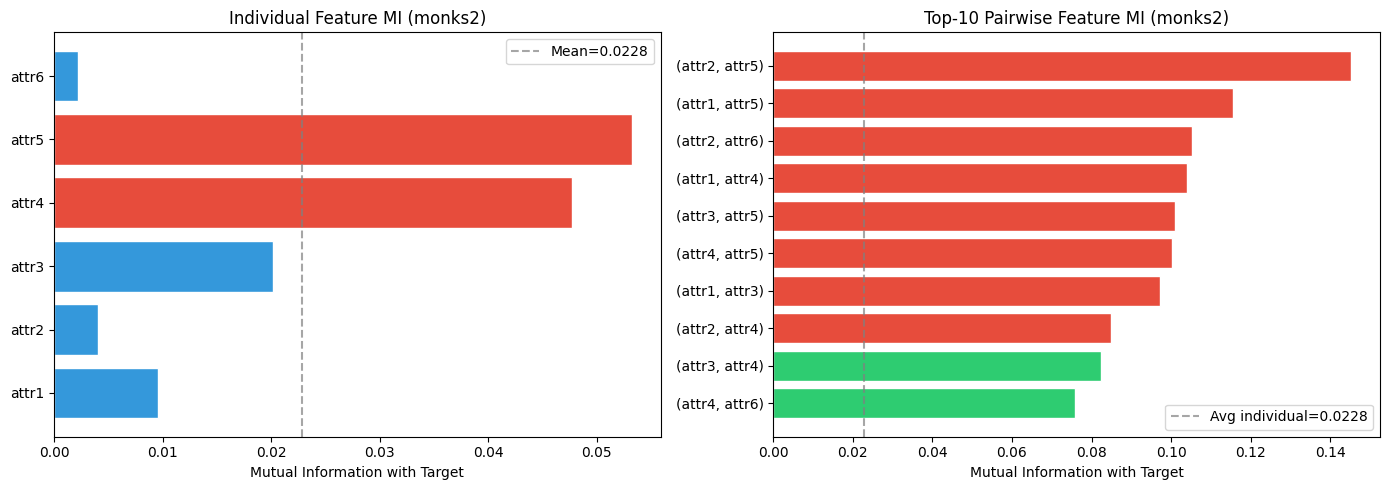


Saved: mi_analysis.png


In [9]:
# ── Summary Table ─────────────────────────────────────────────────
print("Dataset Summary")
print("-" * 55)
print(f"{'Dataset':<12} {'Examples':>8} {'Features':>9} {'Domain'}")
print("-" * 55)
for ds in datasets_out:
    ex0 = ds["examples"][0]
    n_feat = ex0["metadata_n_features"]
    domain = ex0["metadata_domain"]
    print(f"{ds['dataset']:<12} {len(ds['examples']):>8} {n_feat:>9} {domain}")
print("-" * 55)
print(f"{'TOTAL':<12} {total_examples:>8}")

# ── MI Visualization ──────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Individual feature MI
ax1 = axes[0]
colors = ['#e74c3c' if mi > np.mean(individual_mi) else '#3498db' for mi in individual_mi]
bars1 = ax1.barh(mi_feature_names, individual_mi, color=colors, edgecolor='white')
ax1.set_xlabel("Mutual Information with Target")
ax1.set_title("Individual Feature MI (monks2)")
ax1.axvline(x=np.mean(individual_mi), color='gray', linestyle='--', alpha=0.7, label=f'Mean={np.mean(individual_mi):.4f}')
ax1.legend()

# Right: Top-10 pairwise MI
ax2 = axes[1]
sorted_pairs = sorted(zip(pair_mis, pair_labels), reverse=True)
top_n = min(10, len(sorted_pairs))
top_mis = [p[0] for p in sorted_pairs[:top_n]]
top_labels = [p[1] for p in sorted_pairs[:top_n]]
colors2 = ['#e74c3c' if mi > np.mean(pair_mis) else '#2ecc71' for mi in top_mis]
bars2 = ax2.barh(top_labels[::-1], top_mis[::-1], color=colors2[::-1], edgecolor='white')
ax2.set_xlabel("Mutual Information with Target")
ax2.set_title(f"Top-{top_n} Pairwise Feature MI (monks2)")
ax2.axvline(x=np.mean(individual_mi), color='gray', linestyle='--', alpha=0.7, label=f'Avg individual={np.mean(individual_mi):.4f}')
ax2.legend()

plt.tight_layout()
plt.savefig("mi_analysis.png", dpi=100, bbox_inches="tight")
plt.show()
print("\nSaved: mi_analysis.png")